## Submission By: Venki Ramachandran
## Dated: 30-Oct-2021
## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
1. Defining epsilon-greedy strategy
2. Tracking state-action pairs for convergence
3. Define hyperparameters for the Q-learning algorithm
4. Generating episode and applying Q-update equation
5. Checking convergence in Q-values

### Mount Google Drive to Load the python file for the environment setup

In [41]:
# Read the env.py file from google drive
# In case if we are running this code in google colab.
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/Othercomputers/Xylem Mac Laptop/UpGrad/Chapters/30_Reinforcement_Learning/RL_TicTacToe_Assignment")
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
__pycache__  TicTacToeGameEnvSetup.py  TicTacToe_RLAgent.ipynb


#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [42]:
from TicTacToeGameEnvSetup import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [43]:
## Create the env object from your class
env = TicTacToe()

In [44]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | x | 5
#   ----------
#   x | x | x
#   ----------
#   x | x | 4

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [45]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]]
    return valid_Actions

In [46]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

In [47]:
# Check the current State  and the  default tic tac toe board positions
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

In [48]:
# Printing all the valid actions initially when all positions are open
# SInce the agent can only start with odd numbers, in all the 9 positions the agent can put 1,3,5,7,9
valid_actions(env.state)

[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

#### Epsilon-greedy strategy

In [49]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    # print(epsilon)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]    #Exploration: randomly choosing and action
    
    return action


#### Tracking the state-action pairs for checking convergence - write your code here

In [50]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [51]:
# Initialise states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),
                      ('x-x-x-x-x-x-x-x-x',(1,9)),
                      ('x-3-x-x-1-x-x-x-x',(7,5)),
                      ('x-5-x-x-x-x-5-7-x',(8,2)),
                      ('x-3-x-x-x-6-x-x-x',(0,1)),
                      ('x-1-x-x-x-x-8-x-x',(2,9)),
                      ('x-x-x-x-6-x-x-x-5',(2,7)),
                      ('x-x-x-x-9-x-6-x-x',(1,7)),
                      ('x-5-x-2-x-x-4-7-x',(0,9)),
                      ('9-x-5-x-x-x-8-x-4',(1,3)),
                      ('2-7-x-x-6-x-x-3-x',(8,5)),
                      ('9-x-x-x-x-2-x-x-x',(2,5)),
                      ('x-x-7-x-x-x-x-x-2',(1,5)),
                      ('5-x-x-x-x-6-x-x-x',(4,9)),
                      ('4-x-x-6-x-x-3-1-x',(8,5)),
                      ('5-x-8-x-x-6-3-x-x',(3,1)),
                      ('x-6-5-x-2-x-x-3-x',(0,7)),
                      ('7-x-5-x-2-x-x-x-6',(1,3))]   #select some Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [52]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [53]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [54]:
initialise_tracking_states()

#### Define hyperparameters

In [65]:
EPISODES = 1000000          # 1M episodes
track_threshold = 100000    # 100K, Print 10 progress commands
LR = 0.01                   # learning rate
GAMMA = 0.9                 # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.001        # epsilon which is the decay rate
threshold = 5000          # no of episodes after which states_tracked has to be saved
policy_threshold = 5000    # no of episodes after which Q dictionary has to be saved

### Q-update loop

In [66]:
import time
start_time = time.time()

# Write your code here
for episode in range(EPISODES):
  env = TicTacToe() # call the environment
  curr_state = env.state    
  done = False  
  add_to_dict(curr_state)  # adding the current state to dictionary
  total_reward = 0
  count = 0

  while done != True:
      curr_state1 = Q_state(curr_state)
      curr_action = epsilon_greedy(curr_state, episode)   # applying epislon method
      next_state, reward, done = env.step(curr_state, curr_action) # getting rewar
      next_state_temp = Q_state(next_state)
      add_to_dict(next_state)

      # Updating rules
      if done != True:
          max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
                #this gets the action corresponding to max q-value of next state
          Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                    - Q_dict[curr_state1][curr_action] ) 
      else:
          Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

      # navigating to next state
      curr_state = next_state
      total_reward += reward
      
  # Track and prinbt status to show progress
  if ((episode + 1) % track_threshold) == 0:
    print('Processed %dM episodes'%(track_threshold * (episode+1)/track_threshold))
    
  #states tracking
  if ((episode+1)%threshold)==0: # After every 2500th episode save the state
    save_tracking_states()
    count += 1
    save_obj(States_track,'States_tracking')
    
  if ((episode+1)% policy_threshold) == 0:  #every 3500th episodes, the Q-dict will be saved
    save_obj(Q_dict,'Policy_Q_dict')

  
# Print Statistics at the end of the run
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracking')   
save_obj(Q_dict,'Policy_Q_dict')
print('Total Time elapsed (in mins):', elapsed_time/60)

Processed 100000M episodes
Processed 200000M episodes
Processed 300000M episodes
Processed 400000M episodes
Processed 500000M episodes
Processed 600000M episodes
Processed 700000M episodes
Processed 800000M episodes
Processed 900000M episodes
Processed 1000000M episodes
Total Time elapsed (in mins): 29.065386684735618


#### Check the Q-dictionary

In [67]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.193959680598736,
              (0, 3): -1.1943535556077165,
              (0, 5): -1.1928435428451483,
              (0, 7): -1.194342353763481,
              (0, 9): -1.193502330240365,
              (1, 1): -1.1939141289643682,
              (1, 3): -1.1947605566154256,
              (1, 5): -1.1936940710475996,
              (1, 7): -1.19383174897591,
              (1, 9): -1.194573106457814,
              (2, 1): -1.193851588103731,
              (2, 3): -1.1944885432569314,
              (2, 5): -1.1941357850235101,
              (2, 7): -1.1941932851425427,
              (2, 9): 5.603107295142992,
              (3, 1): -1.1943293352482476,
              (3, 3): -1.1938496677272477,
              (3, 5): -1.1932010562772464,
              (3, 7): -1.1938558224468248,
              (3, 9): -1.1939704997484621,
              (4, 1): -1.1941565570444783,
              (4, 3): -1.1944515454808773,
              (4, 5): -1

In [68]:
len(Q_dict)

1448882

In [69]:
# try checking for one of the states - that which action your agent thinks is the best
Q_dict['x-x-5-x-x-x-x-x-4']

{(0, 1): -0.21340630615741532,
 (0, 3): -0.21167761463454568,
 (0, 7): -0.21646489085091178,
 (0, 9): -0.210882626269762,
 (1, 1): -0.21096615364341145,
 (1, 3): -0.2129593953304776,
 (1, 7): -0.21249725545916887,
 (1, 9): -0.21169990389580773,
 (3, 1): -0.2135160547639482,
 (3, 3): -0.21432185919278104,
 (3, 7): -0.21207614762414256,
 (3, 9): -0.21822157840379264,
 (4, 1): -0.21618402549781385,
 (4, 3): -0.21352073333901575,
 (4, 7): -0.21432185919278104,
 (4, 9): -0.21336953875980308,
 (5, 1): -0.21694206101985794,
 (5, 3): -0.21506832685783342,
 (5, 7): -0.21657805726519244,
 (5, 9): -0.21108219898916047,
 (6, 1): -0.21685588818547,
 (6, 3): -0.21674027034044624,
 (6, 7): -0.21129784479174651,
 (6, 9): -0.21262090712040546,
 (7, 1): -0.215767477987073,
 (7, 3): -0.2172993993032473,
 (7, 7): -0.2119296004297664,
 (7, 9): -0.21601542499050658}

In [70]:
Q_dict['3-x-5-x-x-x-2-x-4']

{(1, 1): -0.01,
 (1, 7): 0.7725530557207989,
 (1, 9): 0,
 (3, 1): 0,
 (3, 7): 0,
 (3, 9): 0,
 (4, 1): 0,
 (4, 7): 0,
 (4, 9): 0,
 (5, 1): 0,
 (5, 7): 0,
 (5, 9): 0,
 (7, 1): 0,
 (7, 7): 0,
 (7, 9): 0}

### The above is awesome, I already have 3 and 5 in positions 0,2 and it has given the highest reward to putting a '7' in posiition '1', thereby winning the game.

## Hence the RL agent is working properly towards winning the game.

#### Check the states tracked for Q-values convergence

In [71]:
# Write the code for plotting the graphs for state-action pairs tracked
States_track

defaultdict(dict,
            {'2-7-x-x-6-x-x-3-x': {(8, 5): [0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,

<function matplotlib.pyplot.show>

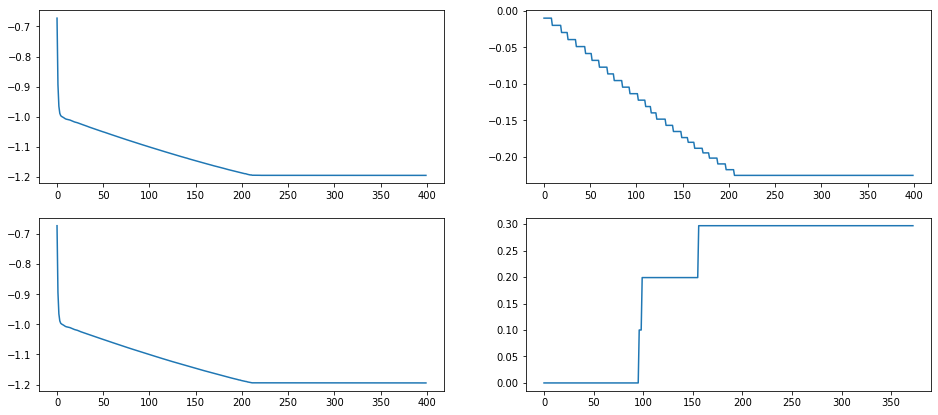

In [72]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-x-6-x-x-x'][(0,1)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-x-6-x-x-x'][(0,1)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-5-x-2-x-x-4-7-x'][(0,9)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-5-x-2-x-x-4-7-x'][(0,9)]))
plt.show


### Epsilon - decay check

In [73]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

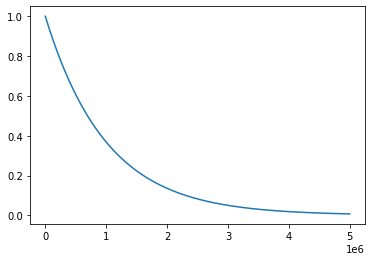

In [74]:
plt.plot(time, epsilon)
plt.show()